In [1]:
from imports import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
warnings.filterwarnings("ignore")

#### Load data, split and create dataset

In [4]:
timeseries = process_file()
len(timeseries)

62

In [5]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [6]:
train.shape

(41, 1)

In [7]:
#window

lookback=1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

print(X_train.shape,  y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([40, 1, 1]) torch.Size([40, 1, 1])
torch.Size([20, 1, 1]) torch.Size([20, 1, 1])


#### Min Max Scaling

In [8]:
scaler_x = MinMaxScaler()
X_train = X_train.squeeze().numpy().reshape(-1, 1)
X_train = torch.tensor(scaler_x.fit_transform(X_train))

X_test = X_test.squeeze().numpy().reshape(-1, 1)
X_test = torch.tensor(scaler_x.transform(X_test))

# crear otro scaler
scaler_y = MinMaxScaler()

y_train = y_train.squeeze().numpy().reshape(-1, 1)
y_train = torch.tensor(scaler_y.fit_transform(y_train))

y_test = y_test.squeeze().numpy().reshape(-1, 1)
y_test = torch.tensor(scaler_y.transform(y_test))

#### Defining LSTM Model and hyperparameters

In [9]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=2, batch_first=True)
        self.linear = nn.Linear(50,1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [81]:
model = LSTMModel()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=14, drop_last=True)

#### Training nnet

In [105]:
torch.manual_seed(42)
np.random.seed(42)

train_loss = []
train_rmse = []

n_epochs = 100
print_interval = 10

for epoch in range(n_epochs):
    model.train()
    epoch_train_loss = 0.0
    epoch_train_rmse = 0.0 
    for X_batch, y_batch in loader:
        # forward pass
        y_pred = model(X_batch)

        # loss
        loss = loss_fn(y_pred, y_batch)
        epoch_train_loss += loss.item()

        # RMSE
        batch_rmse = torch.sqrt(loss)
        epoch_train_rmse += batch_rmse.item()

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % print_interval == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {epoch_train_loss:.4f}, Train RMSE: {epoch_train_rmse:.4f}")
    
    train_loss.append(epoch_train_loss)
    train_rmse.append(epoch_train_rmse)

Epoch 10/100, Train Loss: 0.1278, Train RMSE: 0.5019
Epoch 20/100, Train Loss: 0.1371, Train RMSE: 0.5183
Epoch 30/100, Train Loss: 0.0875, Train RMSE: 0.4162
Epoch 40/100, Train Loss: 0.0873, Train RMSE: 0.4060
Epoch 50/100, Train Loss: 0.1170, Train RMSE: 0.4635
Epoch 60/100, Train Loss: 0.0771, Train RMSE: 0.3896
Epoch 70/100, Train Loss: 0.0823, Train RMSE: 0.4054
Epoch 80/100, Train Loss: 0.1326, Train RMSE: 0.5140
Epoch 90/100, Train Loss: 0.0847, Train RMSE: 0.4110
Epoch 100/100, Train Loss: 0.1159, Train RMSE: 0.4698


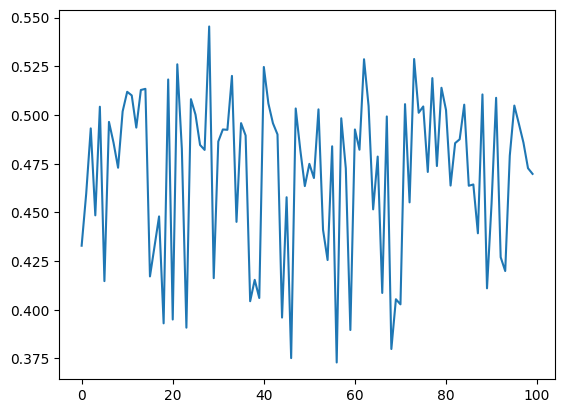

In [106]:
plt.plot(train_rmse)

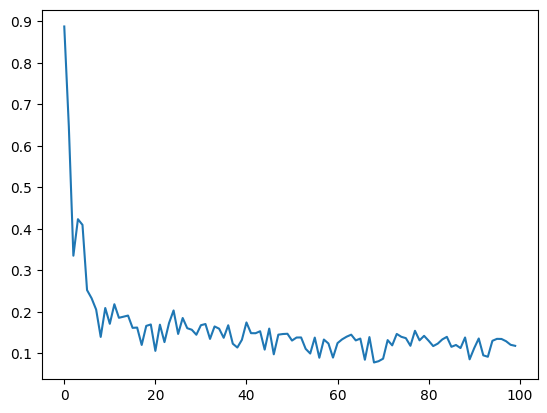

In [87]:
plt.plot(train_loss)

#### Evaluating on train and test

In [103]:
train_preds = []
train_loss = []
test_loss = []
test_rmse = []
gradient_norm = []
test_preds = []

model.eval()

# disable gradient computation
with torch.no_grad():
        y_pred_train = model(X_train)
        y_pred_train_unscaled = scaler_y.inverse_transform(y_pred_train.detach().numpy())
        train_preds.append(y_pred_train_unscaled)          
    
        train_loss.append(loss_fn(y_pred_train, y_train).item())
        train_rmse.append(np.sqrt(loss_fn(y_pred_train, y_train).item()))
    
        y_pred_test = model(X_test)
        y_pred_test_unscaled = scaler_y.inverse_transform(y_pred_test.detach().numpy())
        test_preds.append(y_pred_test_unscaled)
    
        test_loss.append(loss_fn(y_pred_test, y_test).item())
        test_rmse.append(np.sqrt(loss_fn(y_pred_test, y_test).item()))
    

In [104]:
test_loss

[0.05363373085856438]

In [22]:
# creo un array concatenando las predicciones
train_array = np.concatenate([tensor.flatten() for tensor in train_preds])
test_array = np.concatenate([tensor.flatten() for tensor in test_preds])
len(train_array), len(test_array)

(40, 20)

In [23]:
len(test)

21

#### Plotting results

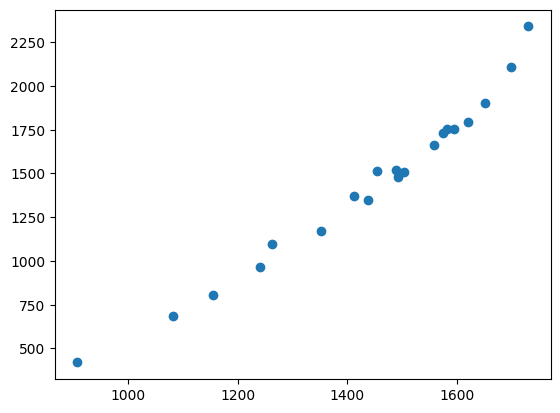

In [24]:
plt.scatter(test_array, test[:20])

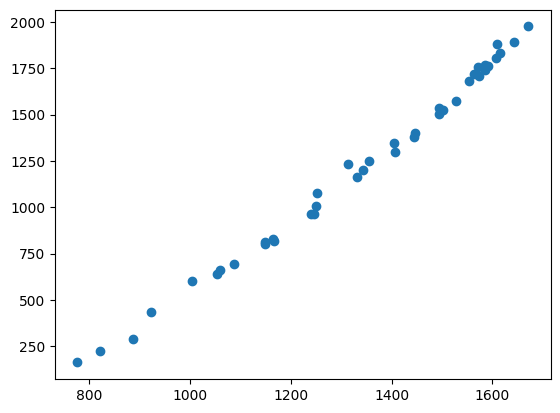

In [25]:
plt.scatter(train_array, train[:40])

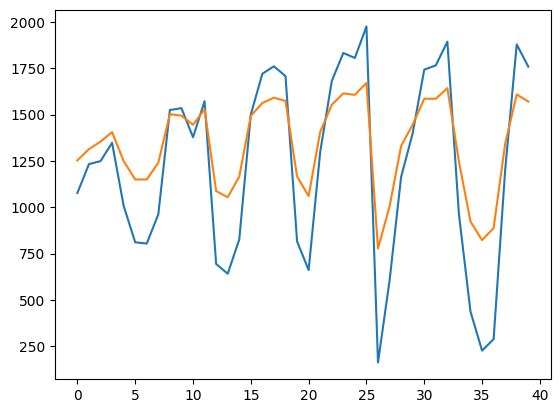

In [26]:
plt.plot(train[:40])
plt.plot(train_array)

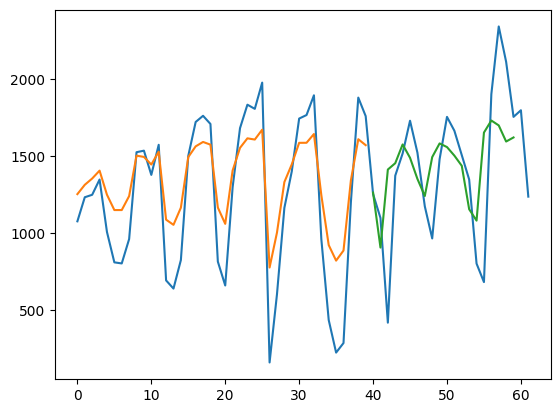

In [71]:
plt.plot(timeseries)
plt.plot(train_array)
plt.plot(range(40, 40+len(test_array)), test_array)

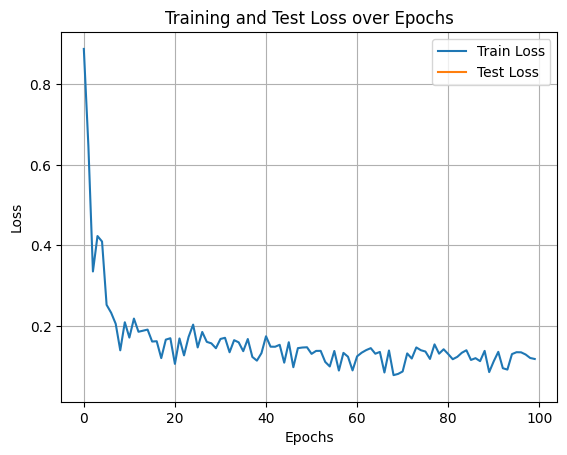

In [94]:
#epochs = range(0, n_epochs, 10)

#plt.plot(epochs, train_loss, label='Train Loss')
#plt.plot(epochs, test_loss, label='Test Loss')

plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')

plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

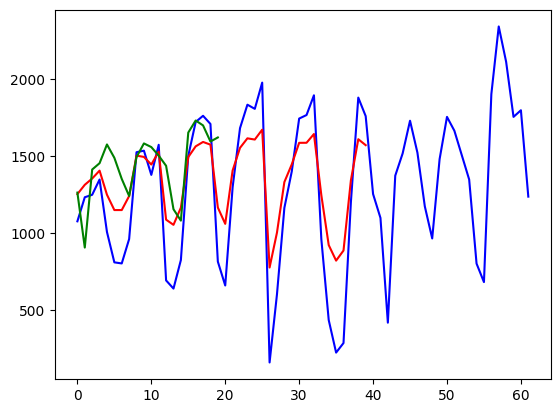

In [67]:
train_plot = np.ones_like(timeseries)  * np.nan
train_plot = train_plot[lookback:train_size]
train_plot = train_array

## shift test predictions for plotting
test_plot = np.ones_like(timeseries) * np.nan
test_plot = test_plot[train_size+lookback:len(timeseries)] 
test_plot = test_array

plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')


In [65]:
train_plot.shape

(40,)

In [57]:
train_plot = train_plot[lookback:train_size]  = train_array

In [62]:
train_plot = train_array

In [63]:
train_plot

array([1253.317  , 1313.7024 , 1354.4567 , 1405.5566 , 1249.4705 ,
       1150.0302 , 1149.9888 , 1240.6342 , 1502.6829 , 1494.546  ,
       1445.0431 , 1528.3623 , 1087.6647 , 1054.2032 , 1165.5781 ,
       1493.6206 , 1562.8752 , 1591.5281 , 1573.9537 , 1166.2662 ,
       1060.62   , 1406.5234 , 1553.2705 , 1614.931  , 1607.0132 ,
       1671.0553 ,  777.5413 , 1004.08716, 1331.4321 , 1445.9065 ,
       1585.7296 , 1586.1259 , 1642.9519 , 1246.5847 ,  923.0087 ,
        822.21985,  887.55695, 1342.828  , 1609.2106 , 1570.7059 ],
      dtype=float32)

In [54]:
train_plot.shape

(62, 1)

In [55]:
timeseries.shape

(62, 1)